# M2 Innovation Technologique et Entrepreunariat
## Introduction au Machine Learning en situation

Auteurs: Guillaume Corlay, Marie Crappe & Livia Sossou

Date de la dernière modification du notebook : 9 janvier 2017

Modèle prédictif pour le challenge DataScience.net intitulé `ANAP-ATIH`

## 0. Set up

In [1]:
# The following command imports numpy as np and matplotlib as plt
%pylab inline
import pandas as pd
import multiprocessing
import re
import gc

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence

from sklearn.cross_validation import KFold, cross_val_score
from itertools import combinations
#from joblib import Parallel, delayed  

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## 1. Chargement des données

In [2]:
train = pd.read_csv('../data/data2.csv', sep=';')
additional_data = pd.read_csv('../data/aggregated_hospidiag_data_reduced.csv', sep=';')
train.tail(5)

,Finess,Raison sociale,Provenance des patients (département),Domaines d activités,"âge (deux classes >75 ans, <= 75 ans)",Nombre de séjours/séances MCO des patients en ALD,Nombre total de séjours/séances,annee,cible1
1879837,970466751,SARL AVICENNE,976-Mayotte,D11-Ophtalmologie,<=75 ans,0,1,2013,0.0
1879838,970466751,SARL AVICENNE,Inconnu,D02-Orthopédie traumatologie,<=75 ans,0,1,2013,0.0
1879839,970466751,SARL AVICENNE,Inconnu,D11-Ophtalmologie,<=75 ans,0,12,2013,0.0
1879840,970466751,SARL AVICENNE,Inconnu,D11-Ophtalmologie,>75 ans,0,1,2013,0.0
1879841,970466751,SARL AVICENNE,Inconnu,D20-Tissu cutané et tissu sous-cutané,<=75 ans,0,2,2013,0.0


In [19]:
train.columns = ['finess', 'RS', 'Dept', 'Activite', 'Age', 'Nb_MCO', 'Nb_Sejours', 'annee', 'Target']
train.loc[train.Age == '<=75 ans', 'Age'] = 0
train.loc[train.Age == '>75 ans', 'Age'] = 1

In [20]:
# On sépare les cliniques 'privées' des CH et hôpitaux
prive = re.compile('CLINIQUE')
train['RS_prive'] = train.RS.apply(lambda x: len(re.findall(prive, x)))
train.drop('RS', axis=1, inplace=True)
train.head(5)

,finess,Dept,Activite,Age,Nb_MCO,Nb_Sejours,annee,Target,RS_prive
0,10007300,01-Ain,D01-Digestif,0,19,1061,2008,0.010624,1
1,10007300,01-Ain,D01-Digestif,1,5,48,2008,0.053320,1
2,10007300,01-Ain,D07-Cardio-vasculaire (hors cathétérismes vasc...,0,0,1,2008,0.000000,1
3,10007300,01-Ain,D16-Hématologie,0,0,17,2008,0.000000,1
4,10007300,01-Ain,D16-Hématologie,1,0,2,2008,0.000000,1


In [21]:
merged_data = train.merge(additional_data, on=['finess', 'annee'])
merged_data.head()

,finess,Dept,Activite,Age,Nb_MCO,Nb_Sejours,annee,Target,RS_prive,Unnamed: 0,...,CI_F7_O,CI_F8_D,CI_F8_O,CI_F9_D,CI_F9_O,P8,P8new,P9,RH1,cat
0,280000449,78-Yvelines,D18-Maladies infectieuses (dont VIH),0,0,1,2008,0.000000,1,2008,...,4128984.0,-4.0,-3.0,-4.0,-371168.0,-4.0,-4.0,-4.0,-4.0,3
1,280000449,78-Yvelines,D19-Endocrinologie,0,0,3,2008,0.000000,1,2008,...,4128984.0,-4.0,-3.0,-4.0,-371168.0,-4.0,-4.0,-4.0,-4.0,3
2,280000449,78-Yvelines,D19-Endocrinologie,1,0,1,2008,0.000000,1,2008,...,4128984.0,-4.0,-3.0,-4.0,-371168.0,-4.0,-4.0,-4.0,-4.0,3
3,280000449,78-Yvelines,"D23-Toxicologie, Intoxications, Alcool",1,1,1,2008,0.124902,1,2008,...,4128984.0,-4.0,-3.0,-4.0,-371168.0,-4.0,-4.0,-4.0,-4.0,3
4,280000449,78-Yvelines,"D26-Activités inter spécialités, suivi thérape...",1,1,1,2008,0.124092,1,2008,...,4128984.0,-4.0,-3.0,-4.0,-371168.0,-4.0,-4.0,-4.0,-4.0,3


In [22]:
del train
del additional_data
gc.collect()

614

In [23]:
le = preprocessing.LabelEncoder()
merged_data.Activite = le.fit_transform(merged_data.Activite)
merged_data.cat = le.fit_transform(merged_data.cat)
merged_data.Dept = le.fit_transform(merged_data.Dept)
merged_data.head()

,finess,Dept,Activite,Age,Nb_MCO,Nb_Sejours,annee,Target,RS_prive,Unnamed: 0,...,CI_F7_O,CI_F8_D,CI_F8_O,CI_F9_D,CI_F9_O,P8,P8new,P9,RH1,cat
0,280000449,78,16,0,0,1,2008,0.000000,1,2008,...,4128984.0,-4.0,-3.0,-4.0,-371168.0,-4.0,-4.0,-4.0,-4.0,3
1,280000449,78,17,0,0,3,2008,0.000000,1,2008,...,4128984.0,-4.0,-3.0,-4.0,-371168.0,-4.0,-4.0,-4.0,-4.0,3
2,280000449,78,17,1,0,1,2008,0.000000,1,2008,...,4128984.0,-4.0,-3.0,-4.0,-371168.0,-4.0,-4.0,-4.0,-4.0,3
3,280000449,78,21,1,1,1,2008,0.124902,1,2008,...,4128984.0,-4.0,-3.0,-4.0,-371168.0,-4.0,-4.0,-4.0,-4.0,3
4,280000449,78,24,1,1,1,2008,0.124092,1,2008,...,4128984.0,-4.0,-3.0,-4.0,-371168.0,-4.0,-4.0,-4.0,-4.0,3


<h2> 2. Split des données </h2>

In [24]:
N_split = int(round(len(merged_data)*0.80))

df_train = merged_data.iloc[:N_split]
df_test = merged_data.iloc[N_split:]

ytrain = df_train['Target']
ytest = df_test['Target']

df_train = df_train.drop('Target', axis=1)
df_train = df_train.drop('finess', axis=1)

df_test = df_test.drop('Target', axis=1)
df_test = df_test.drop('finess', axis=1)

In [25]:
#del merged_data
#gc.collect()

## 3. Imputation des données manquantes

In [26]:
# Traitement des variables manquantes
imputer = preprocessing.Imputer()
xtrain = imputer.fit_transform(df_train)
xtest = imputer.transform(df_test)

## 4. Random Forest

In [ ]:
# Nombre d'arbres à tester
params = [i for i in range(1,20,1)]

In [ ]:
# Méthode permettant l'entraînement et l'évaluation des modèles, ainsi que l'affichage des résultats
def show_errors(X_train, y_train, X_valid, y_valid, criterion, error) :
    train_scores = []
    validation_scores = []
    j = 0
    
    for i in params:
        regressor = RandomForestRegressor(n_estimators=20, max_depth = i, n_jobs=-1, criterion='mse') 
        regressor.fit(X_train, y_train)

        # CHANGER LE CALCUL DES SCORES !!!
        train_scores.append(mean_squared_error(regressor.predict(X_train), y_train))
        validation_scores.append(mean_squared_error(regressor.predict(X_valid), y_valid))
        print(i)
        print('training set: ', train_scores[j])
        print('validation set: ', validation_scores[j])
        j = j + 1
    
    # Visualisation des résultats
    plt.figure(figsize=(15,8))

    plt.plot(nb_trees, train_scores, c='b') 
    plt.plot(nb_trees, validation_scores, c='r') 
    
    plt.title("%s en fonction du nombre d'arbres" % error)
    plt.xlabel("Profondeur maximale de l'arbre")
    plt.ylabel("%s" % error)
    plt.legend(["Apprentissage", "Validation"], loc='upper right')

    plt.show()
    
    return validation_scores 

In [ ]:
temp = show_errors(xtrain, ytrain, xtest, ytest, "mse", "Mean Squared Error")

In [27]:
rd = RandomForestRegressor(n_estimators=10, n_jobs=-1)
rd.fit(xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [28]:
rd_preds = rd.predict(xtest)
print("rmse:      {}".format(sqrt(mean_squared_error(ytest, rd_preds))))

rmse:      0.0464219337368326


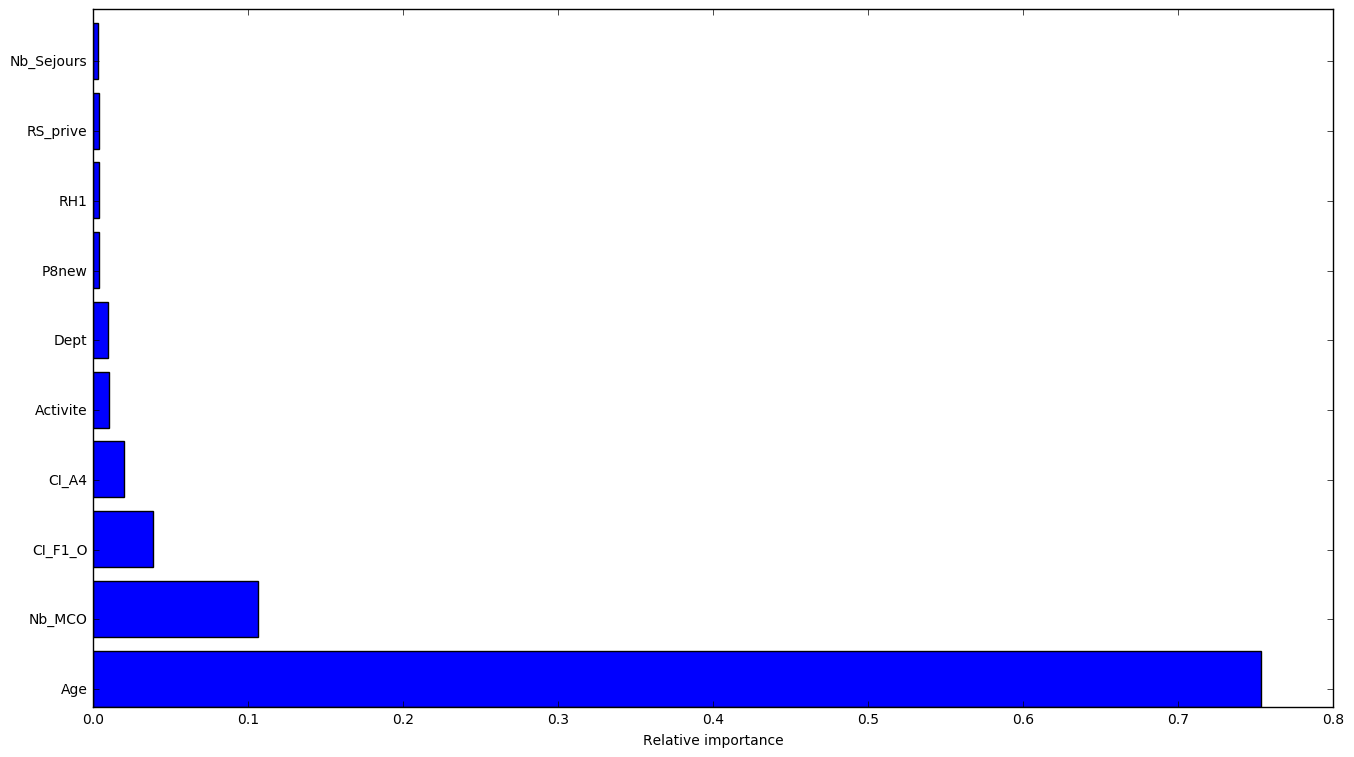

In [29]:
# sort importances
plt.figure(figsize=(16,9))
features_names = merged_data.drop('Target', axis=1).columns.values
indices = np.argsort(rd.feature_importances_)[::-1]
indices = indices[:10]
# plot as bar chart
plt.barh(np.arange(10), rd.feature_importances_[indices])
plt.yticks(np.arange(10) + 0.25, np.array(features_names)[indices])
_ = plt.xlabel('Relative importance')

without dummies & 100 trees => rmse: 0.061686654295611515 <br>
with dummies & 100 trees => rmse: 0.06043873775392981

## 6. Gradient Boosted Machines

In [30]:
gbm = GradientBoostingRegressor()
gbm.fit(xtrain,ytrain)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [31]:
gbm_preds = gbm.predict(xtest)
print("rmse:      {}".format(sqrt(mean_squared_error(ytest, gbm_preds))))

rmse:      0.052154834769668486
